In [ ]:
import torch
import torchvision
import matplotlib.pyplot as plt

In [ ]:
# download the data
training_data = torchvision.datasets.MNIST(
    root='./data', # where to save it
    train=True,
    download=True,
    transform=torchvision.transforms.ToTensor(),
)

test_data = torchvision.datasets.MNIST(
    root='./data',
    train=False, # create test data
    download=True,
    transform=torchvision.transforms.ToTensor(),
)

In [ ]:
# data looks like [(img, label), (img, label), ...]

classes = list(set([l for i,l in training_data]))

fig, ax = plt.subplots(figsize=(8,8), ncols=3, nrows=3)

for i in range(3):
    for j in range(3):
        sample_idx = torch.randint(len(training_data), size=(1,)).item()
        img, label = training_data[sample_idx]

        ax[i, j].imshow(img.squeeze(), cmap="gray")
plt.show()

A `torch.utils.data.Dataset` loads data one sample at a time by reading each data point from memory, one-by-on, on-demand. Data is not loaded until we try to "index" the dataset like `myDataset[10]`, at which point an image is loaded and returned. A custom `Dataset` must implement
- `__init__`
- `__len__`
- `__getitem__`

In [ ]:
import os
import pandas as pd

class CustomImageDataset(torch.utils.data.Dataset):

    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        """Init directory containing the data, annotations file, and both transforms."""
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return self(self.img_labels)

    def __getitem__(self, idx):
        """Load and return a sample from the dataset, by index. Loads and 
        transforms each image on-demand."""
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = torchvision.io.read_image(img_path)
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

Data is typically passed to training routines and models in batches. `torch.utils.data.DataLoader` simplifies this.

In [1]:
import torch
import torchvision
import matplotlib.pyplot as plt
import numpy as np

# download the data
training_data = torchvision.datasets.MNIST(
    root='./data', # where to save it
    train=True,
    download=True,
    transform=torchvision.transforms.ToTensor(),
)

test_data = torchvision.datasets.MNIST(
    root='./data',
    train=False, # create test data
    download=True,
    transform=torchvision.transforms.ToTensor(),
)

train_dl = torch.utils.data.DataLoader(training_data, batch_size=64, shuffle=True)
test_dl = torch.utils.data.DataLoader(test_data, batch_size=64, shuffle=True)


/home/DKS0559531/miniconda3/envs/torch/lib/python3.10/site-packages/torchvision/io/image.py:11: UserWarning: Failed to load image Python extension: /home/DKS0559531/miniconda3/envs/torch/lib/python3.10/site-packages/torchvision/image.so: undefined symbol: _ZN5torch3jit17parseSchemaOrNameERKNSt7__cxx1112basic_stringIcSt11char_traitsIcESaIcEEE
  warn(f"Failed to load image Python extension: {e}")


We can now iterate through the data in batches

In [2]:
train_features, train_labels = next(iter(train_dl))

In [3]:
train_features[0].shape # n_channels, height, width

torch.Size([1, 28, 28])

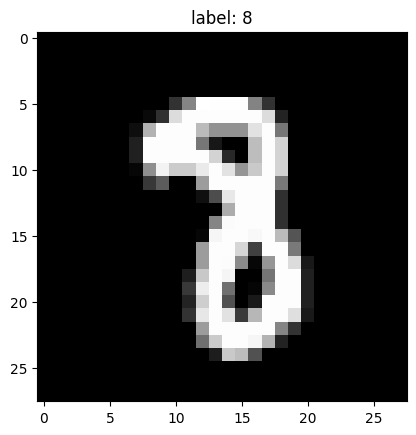

In [4]:
img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(img, cmap='gray')
plt.title(f"label: {label}")
plt.show()

In [5]:
conv1 = torch.nn.Sequential(
    torch.nn.Conv2d(
        in_channels=1,
        out_channels=16,
        kernel_size=5,
        stride=1,
        padding=2,
        ),
    torch.nn.ReLU(),
    torch.nn.MaxPool2d(2,2),
)

conv2 = torch.nn.Sequential(
    torch.nn.Conv2d(
        in_channels=16,
        out_channels=32,
        kernel_size=5,
        stride=1,
        padding=2,
    ),
    torch.nn.ReLU(),
    torch.nn.MaxPool2d(2,2),
)

flatten = torch.nn.Flatten(1) # retain batch dim

linear = torch.nn.Linear(32*7*7, 10)

# output = torch.nn.Softmax(dim=1)


model = torch.nn.Sequential(
    conv1,
    conv2,
    flatten,
    linear,
    # output,
)

print(model)

Sequential(
  (0): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (1): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (2): Flatten(start_dim=1, end_dim=-1)
  (3): Linear(in_features=1568, out_features=10, bias=True)
)


In [6]:
loss_fn = torch.nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

In [7]:
def train_loop(n_epochs, model, loss_fn, optimizer, loaders):

    losses = torch.zeros(n_epochs)

    for epoch in range(n_epochs):
        print(f"Epoch: {epoch:>4d}")
        batch_losses = []
        # iterate over data loader
        for batch_idx, batch in enumerate(loaders['train']):
            # print(batch[1])
            # break
            batch_X, batch_y = batch

            # forward propagation
            batch_y_pred = model(batch_X)
            
            # calc loss
            batch_loss = loss_fn(batch_y_pred, batch_y)

            # backprop
            optimizer.zero_grad()
            batch_loss.backward()
            optimizer.step()

            batch_losses.append(batch_loss.item())
        
        losses[epoch] = torch.mean(torch.tensor(batch_losses))
    return losses



loaders = {
    "train": train_dl,
    "test": test_dl,
}

losses = train_loop(n_epochs=10, model=model, loss_fn=loss_fn, optimizer=optimizer, loaders=loaders)

Epoch:    0
Epoch:    1
Epoch:    2
Epoch:    3
Epoch:    4
Epoch:    5
Epoch:    6
Epoch:    7
Epoch:    8
Epoch:    9


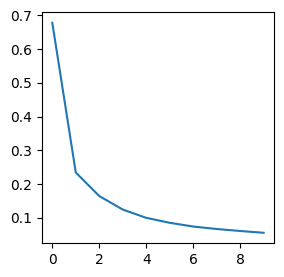

In [9]:
plt.figure(figsize=(3,3))
plt.plot(losses.numpy())
plt.show()

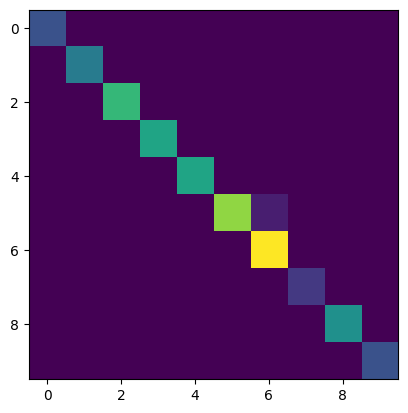

In [10]:
batch_X, batch_y =  next(iter(test_dl))

y_pred_proba = model(batch_X)
y_pred = y_pred_proba.argmax(axis=1)

from sklearn.metrics import confusion_matrix

cm = confusion_matrix(batch_y, y_pred)
plt.imshow(cm)

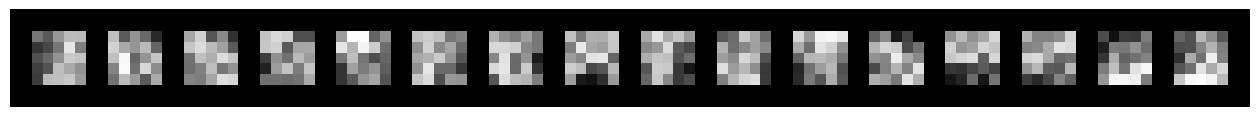

In [14]:

layer = 0
filters = model[layer][0].weight.data.clone()

n_cols = 16

n_filters, n_channels, w, h = filters.shape

# only plot n_rows * n_rows filters
filters = filters.view(n_filters * n_channels, -1, w, h)
rows = np.min((filters.shape[0] // n_cols + 1, 64))

plt.figure(figsize=(n_cols, rows))
grid = torchvision.utils.make_grid(
    filters,
    nrow=n_cols,
    normalize=True,
).numpy().transpose((1,2,0))
plt.imshow(grid)
plt.axis('off')
plt.ioff()
plt.show()


### Try again but with larger filters

In [29]:
from torch.nn import ReLU, Flatten, MaxPool2d

# in_channels, out_channels, kernel_size, stride, padding
class ConvNN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = torch.nn.Conv2d(1,16,5,1,2)
        self.conv2 = torch.nn.Conv2d(16,32,5,1,2)
        self.linear = torch.nn.Linear(32*7*7, 10)
        self.pool = MaxPool2d(2,2)
        self.relu = ReLU()

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = Flatten(1)(x)
        x = self.linear(x)
        return x


model = ConvNN()

print(model)

ConvNN(
  (conv1): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (linear): Linear(in_features=1568, out_features=10, bias=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (relu): ReLU()
)


In [64]:
loss_fn = torch.nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

In [65]:
# def train_loop(n_epochs, model, loss_fn, optimizer, loaders):

#     losses = torch.zeros(n_epochs)

#     for epoch in range(n_epochs):
#         print(f"Epoch: {epoch:>4d}")
#         batch_losses = []
#         # iterate over data loader
#         for batch_idx, batch in enumerate(loaders['train']):
#             # print(batch[1])
#             # break
#             batch_X, batch_y = batch

#             # forward propagation
#             batch_y_pred = model(batch_X)
            
#             # calc loss
#             batch_loss = loss_fn(batch_y_pred, batch_y)

#             # backprop
#             optimizer.zero_grad()
#             batch_loss.backward()
#             optimizer.step()

#             batch_losses.append(batch_loss.item())
        
#         losses[epoch] = torch.mean(torch.tensor(batch_losses))
#     return losses



loaders = {
    "train": train_dl,
    "test": test_dl,
}

losses = train_loop(n_epochs=10, model=model, loss_fn=loss_fn, optimizer=optimizer, loaders=loaders)

Epoch:    0
Epoch:    1
Epoch:    2
Epoch:    3
Epoch:    4
Epoch:    5
Epoch:    6
Epoch:    7
Epoch:    8
Epoch:    9


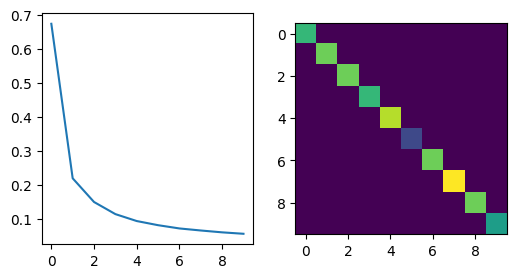

In [67]:
fig, ax = plt.subplots(ncols=2,figsize=(6,3))
ax[0].plot(losses.numpy())

batch_X, batch_y =  next(iter(test_dl))

y_pred_proba = model(batch_X)
y_pred = y_pred_proba.argmax(axis=1)

from sklearn.metrics import confusion_matrix

cm = confusion_matrix(batch_y, y_pred)
ax[1].imshow(cm)

plt.show()

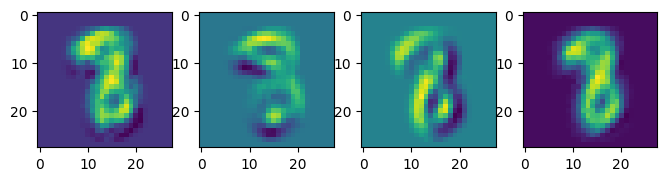

In [68]:
y_pred = model.conv1(train_features[:3]).detach().numpy()

fig, ax = plt.subplots(ncols=4, figsize=(8,4))
for i in range(4):
    ax[i].imshow(y_pred[0][i])
plt.show()

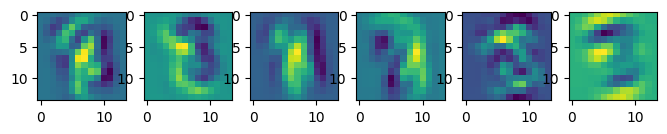

In [69]:
xp = train_features[:3]
y_pred = model.pool(model.relu(model.conv1(xp)))
y_pred = model.conv2(y_pred)

y_pred = y_pred.detach().numpy()

fig, ax = plt.subplots(ncols=6, figsize=(8,4))
for i in range(6):
    ax[i].imshow(y_pred[0][i])
plt.show()

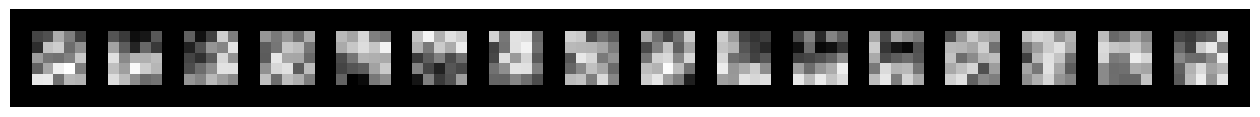

In [72]:
filters = model.conv1.weight.data.clone()

n_cols = 16

n_filters, n_channels, w, h = filters.shape

# only plot n_rows * n_rows filters
filters = filters.view(n_filters * n_channels, -1, w, h)
rows = np.min((filters.shape[0] // n_cols + 1, 64))

plt.figure(figsize=(n_cols, rows))
grid = torchvision.utils.make_grid(
    filters,
    nrow=n_cols,
    normalize=True,
).numpy().transpose((1,2,0))
plt.imshow(grid)
plt.axis('off')
plt.ioff()
plt.show()
